# Learning geometry of geodesics

This is the work done with Samuel Gruffaz on using RKHS to learn the shape of the geodesics.

In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

import sys, os

sys.path.append(os.path.join(os.getcwd(), '..', 'leaspy'))

from leaspy import Leaspy, Data, AlgorithmSettings, Plotter, Dataset, IndividualParameters
from leaspy.models.utils.attributes.attributes_factory import AttributesFactory
from leaspy.algo.algo_factory import AlgoFactory

In [21]:
def generate_data(model, n_individuals, nb_visits_min, nb_visits_mean, window):
    # Sampling individuals :

    N = n_individuals

    individuals = []

    data = [[], []] + [[] for k in range(model.dimension)]

    for i in range(N):
        tau = np.random.normal(loc=model.parameters['tau_mean'], scale=model.parameters['tau_std'])
        xi = np.random.normal(loc=model.parameters['xi_mean'], scale=model.parameters['xi_std'])
        n_tpts = nb_visits_min + np.random.binomial(nb_visits_mean-nb_visits_min,0.5)
        tpts = np.sort((np.random.normal(0., 1., size=(n_tpts)) * window) + tau)
        timepoints = torch.tensor(tpts, dtype=float)
        sources = None
        if model.source_dimension is not None:
            sources = np.random.normal(loc=model.parameters['sources_mean'], scale=model.parameters['sources_std'], size=(model.source_dimension))
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi), "sources":torch.Tensor(sources)}).detach().numpy()
        else:   
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi)}).detach().numpy()
        values = values + np.random.normal(0., model.parameters['noise_std'], size=(n_tpts, model.dimension))
        individuals.append({"idx":i+1, "tau":tau, "xi":xi, "tpts":tpts, "sources":sources, "values":values})
        data[0] += [i+1] * n_tpts
        data[1] += list(tpts)
        for k in range(model.dimension):
            data[2+k] += list(values[0, :, k])
    data = np.array(data).T
    df = pd.DataFrame(data, columns=['ID', 'TIME']+["Y"+str(k+1) for k in range(model.dimension)])
    df.set_index(['ID', 'TIME'], inplace=True)
    return data, individuals

In [30]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[1., 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.1]}
model1 = leaspy.model
model1.dimension = dimension
model1.source_dimension = sources_dimension
model1.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
model1.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
model1.attributes._compute_positions(model1.parameters)
model1.attributes._compute_velocities(model1.parameters)
model1.attributes._compute_betas(model1.parameters)
model1.attributes._compute_orthonormal_basis()
model1.attributes._compute_mixing_matrix()
model1.is_initialized = True
model1.B = lambda x : x + torch.cos(x)

In [31]:
n_individuals = 100
nb_visits_min = 2
nb_visits_mean = 6
window = 10.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

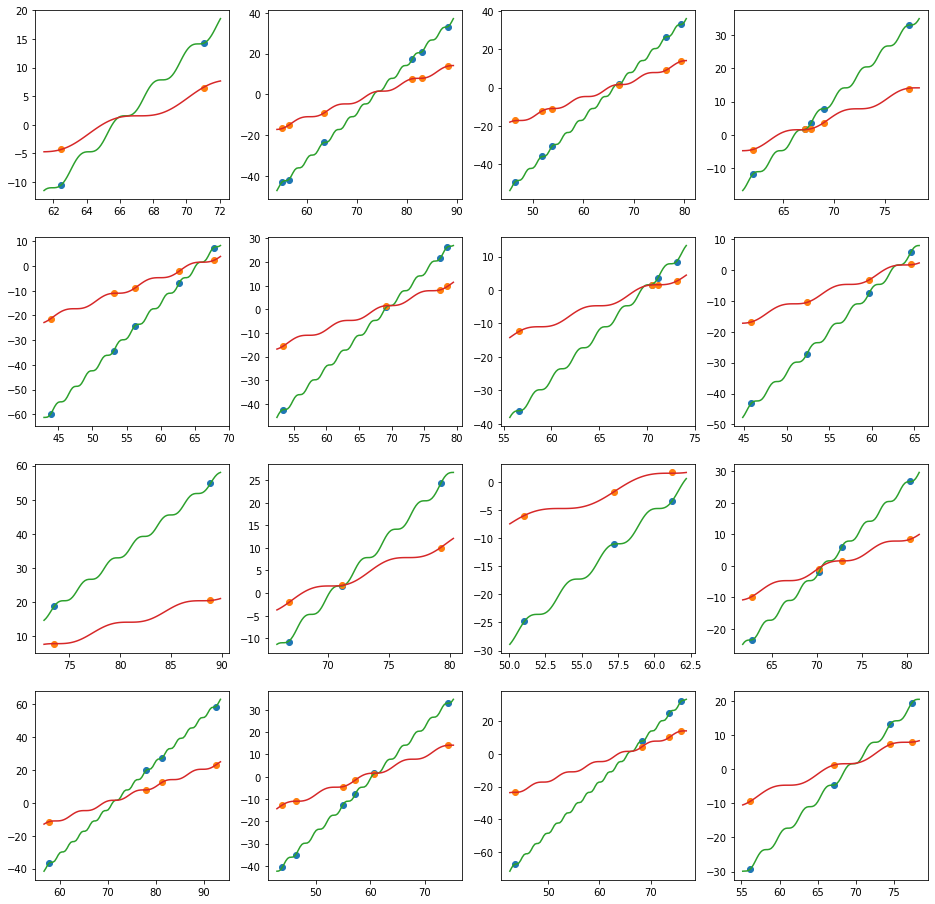

In [32]:
fig, ax = plt.subplots(4,4, figsize=(16,16))

k = 0
for i in range(4):
    for j in range(4):
        ax[i,j].plot(individuals[k]['tpts'], individuals[k]['values'][0], "o")
        params = individuals[k]
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model1.compute_individual_tensorized(t, mean_par).squeeze(0)
        ax[i,j].plot(t, trajectory)
        k += 1
plt.show()